## Importowanie bibliotek

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import pickle

from keras import Input
from keras.src.layers import Dropout
from keras.src.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.svm import SVC

## Załadowanie zmiennych

In [2]:
with open('data_dump/dataAnalysisVars.pkl', 'rb') as f:
    df = pickle.load(f)
    
    df_0 = pickle.load(f)
    df_mean = pickle.load(f)
    df_interpolate = pickle.load(f)
    
    normalized_0 = pickle.load(f)
    scaler_0 = pickle.load(f)
    
    normalized_mean = pickle.load(f)
    scaler_mean = pickle.load(f)
    
    normalized_interpolate = pickle.load(f)
    scaler_interpolate = pickle.load(f)

## Funkcje do podziału zbioru danych

In [3]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)
    
    test_size = int(test_size * len(data))
    test_indices = np.random.choice(data.index, size=test_size, replace=False)
    train_indices = np.setdiff1d(data.index, test_indices)
    
    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]
    
    return train_set, test_set

def split_df_train_val_test(data, val_size, test_size, seed):
    np.random.seed(seed)
    
    val_size = int(val_size * len(data))
    test_size = int(test_size * len(data))
    
    val_test_indices = np.random.choice(data.index, size=val_size + test_size, replace=False)
    
    val_indices = val_test_indices[:val_size]
    test_indices = val_test_indices[val_size:]
    
    train_indices = np.setdiff1d(data.index, val_test_indices)
    
    train_set = data.loc[train_indices]
    val_set = data.loc[val_indices]
    test_set = data.loc[test_indices]
    
    return train_set, val_set, test_set

## SVM - Scikit-Learn

In [4]:
class SVMClassifierWrapper:
    
    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = SVC(random_state=42)
        
    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 5, 10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'gamma': ['scale', 'auto'],
                'probability': [True, False],
                'degree': [2, 3, 4, 5]
            }
        
        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=160, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 18 + ' SVM ' + '-' * 18)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)


## Random Forest - Scikit-Learn

In [5]:
class RandomForestClassifierWrapper:
    
    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = RandomForestClassifier(random_state=42)
        
    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'max_depth': [5, 10, 20, 30],
                'min_samples_split': [2, 5, 10, 15],
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        
        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=192, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 13 + ' Random Forest ' + '-' * 13)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
       

## MLP - Keras

In [6]:
class MLPClassifierWrapper:

    def __init__(self, train_set, val_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.val_set = val_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.val_label = val_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = Sequential()
        
        self.model.add(Input(shape=(9,)))
        self.model.add(Dense(40, activation='leaky_relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation='leaky_relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(20, activation='leaky_relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self):
         self.history = self.model.fit(self.train_set, self.train_label, epochs=150, batch_size=64, validation_data=(self.val_set, self.val_label))

    def evaluate_model(self):
        test_loss, test_acc = self.model.evaluate(self.test_set, self.test_label)
        print('-' * 18 + ' MLP ' + '-' * 18)
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test loss:', test_loss)
        print('-' * 41)
        
    def plot_results(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        

## Trenowanie modeli

### Split danych

In [7]:
train, test = split_df_train_test(normalized_interpolate, 0.2, 123)
train_mlp, val_mlp, test_mlp = split_df_train_val_test(normalized_interpolate, 0.1, 0.1, 111)

### Trenowanie SVM

In [8]:
modelSVM = SVMClassifierWrapper(train, test)
modelSVM.train_model()
modelSVM.evaluate_model()

------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: False
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.6992366412213741
-----------------------------------------


### Trenowanie Random Forest

In [9]:
modelRF = RandomForestClassifierWrapper(train, test)
modelRF.train_model()
modelRF.evaluate_model()

------------- Random Forest -------------
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 10
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 10
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6809160305343511
-----------------------------------------


### Trenowanie MLP

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4528 - loss: 0.7438 - val_accuracy: 0.5015 - val_loss: 0.6955
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5057 - loss: 0.7006 - val_accuracy: 0.5749 - val_loss: 0.6831
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5470 - loss: 0.6874 - val_accuracy: 0.5902 - val_loss: 0.6780
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5887 - loss: 0.6849 - val_accuracy: 0.5933 - val_loss: 0.6747
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5670 - loss: 0.6864 - val_accuracy: 0.6055 - val_loss: 0.6725
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5889 - loss: 0.6788 - val_accuracy: 0.6116 - val_loss: 0.6706
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6008 - loss: 0.6758 - val_accuracy: 0.6116 - val_loss: 0.6696
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.5857 - loss: 0.6770 - val_accuracy: 0.6

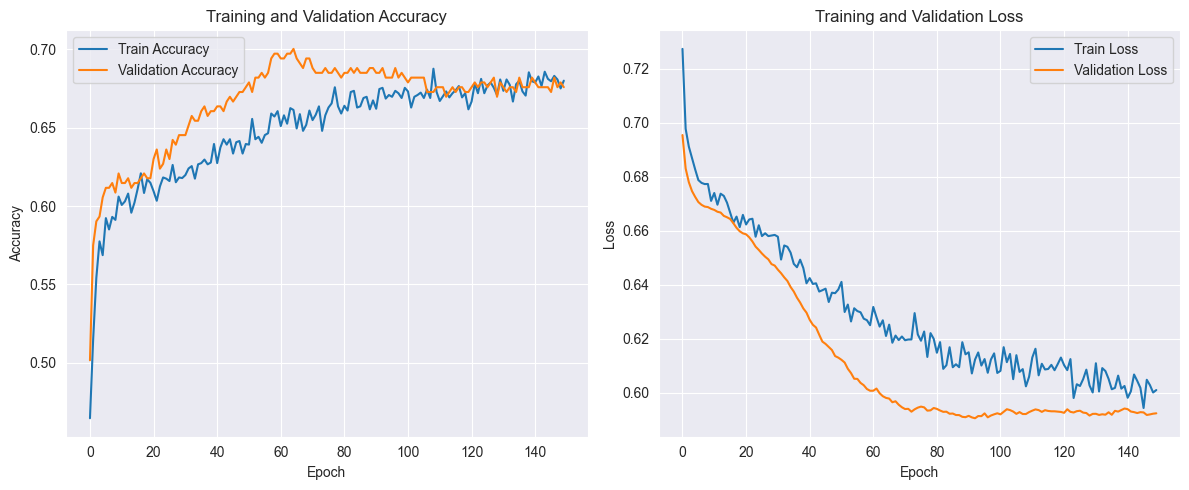

In [10]:
modelMLP = MLPClassifierWrapper(train_mlp, val_mlp, test_mlp)
modelMLP.train_model()
modelMLP.evaluate_model()
modelMLP.plot_results()